In [1]:
REPO = '../'
RESULT_TABLE = f'{REPO}/data/table'
RESULT_OBJ = f'{REPO}/data/object'
FIGURE_FOLDER= f'{REPO}/data/figure'
SETTING_FOLDER = f'{REPO}/data/setting'

import numpy as np
import pandas as pd
import scPipe as sp
import scanpy as sc
import warnings
import sys
import commentjson
sys.path.append(REPO)
import matplotlib.pyplot as plt
from settings import COLOR_PAlETTE
with open(f'{SETTING_FOLDER}/ColorMap.json','r') as f:
    colormap = commentjson.load(f)
COLOR_PAlETTE.update(colormap)
plt.style.use(f'{REPO}/paper.mplstyle')
warnings.filterwarnings("ignore")
sc.settings.figdir = FIGURE_FOLDER
%load_ext autoreload
%autoreload 2
%matplotlib inline

# Load data

In [2]:
COMPARTMENT='Epithelial'
adata = sc.read(f'{RESULT_OBJ}/gex_all.h5ad')
# load metadata
obs = pd.read_csv(f'{RESULT_TABLE}/GEX_OBS.csv',index_col=0)
# load copy number alteration result
scevan = pd.read_csv(f'{RESULT_TABLE}/gex_cnv_SCEVAN_karyotype.csv')
scevan.index = scevan.barcodes +'_'+scevan['Sample']+'_'+scevan.Cohort
for c in ['Sample_Short','Patient','Compartment',
          'Sample','Treatment_Arm','BestResponse','Timepoint']:
    adata.obs[c] = obs[c]
adata.obs['SCEVAN'] = scevan['class']
adata = adata[adata.obs['Compartment']==COMPARTMENT,:]
print(f"Detect N={adata.shape[0]:,} {COMPARTMENT} cells with high quality GEX profiles;")
print(f"max(% of mitocondrial reads): {adata.obs['pct_counts_mito'].max():.0f}")

Detect N=93,621 Epithelial cells with high quality GEX profiles;
max(% of mitocondrial reads): 5


In [3]:
adata.obs['SCEVAN'].value_counts()

tumor       65206
normal      16991
filtered    11424
Name: SCEVAN, dtype: int64

# CNV heatmap

In [4]:
cnv = sc.read(f'{RESULT_OBJ}/gex_cnv_SCEVAN.h5ad')
cnv.var['chrom'] = cnv.var.index.map(lambda x:int(x.split('_')[0]))
cnv.var['start'] = cnv.var.index.map(lambda x:int(x.split('_')[1]))
cnv = cnv[:,cnv.var.sort_values(['chrom','start']).index]
cnv.var['position'] = range(cnv.var.shape[0])
var_group_dict = cnv.var.groupby('chrom')['position'].agg(lambda x: (x.min(),x.max())).to_dict()
cnv.obs['Malignance'] = adata.obs.loc[cnv.obs.index.intersection(adata.obs.index),'SCEVAN']
cnv = cnv[~cnv.obs.Malignance.isna(),:]

## By malignance, all cells

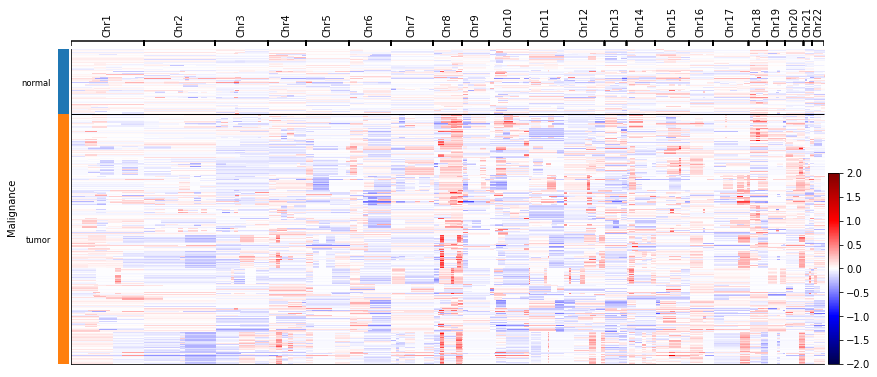

In [5]:
sc.pl.heatmap(cnv,groupby="Malignance",var_names=cnv.var_names,cmap='seismic',
              var_group_positions=list(var_group_dict.values()),
              var_group_labels=list(map(lambda x:f'Chr{x}',var_group_dict.keys())),
              vcenter=0,
              vmax=2,
              vmin=-2,
              figsize=(14,6),
              save='/GEX_CNV_by_malignance.pdf'
)

## By Patient, only show malignant cells

In [6]:
cnv.obs['Patient'] = pd.Categorical(cnv.obs['Sample'].map(lambda x:f"P{x.split('_')[1]}"))
cnv = cnv[cnv.obs.sort_values(['Malignance','Patient']).index,:]
cnv.uns['Patient_colors'] = [ COLOR_PAlETTE['Patient'][x]for x in cnv.obs.Patient.cat.categories]

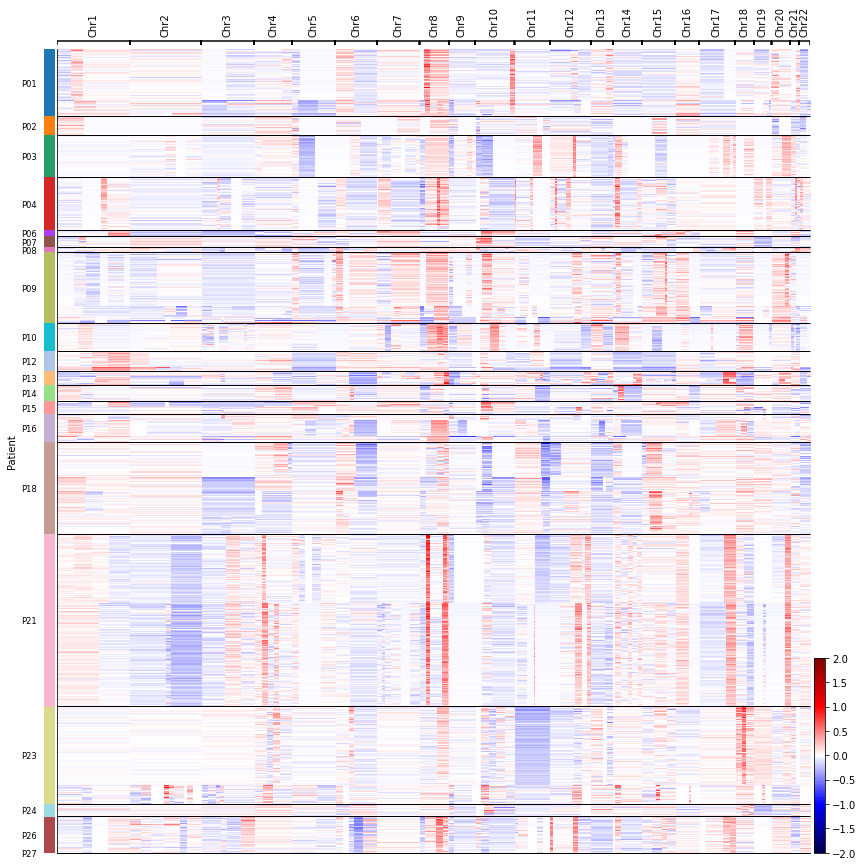

In [7]:
sc.pl.heatmap(cnv[cnv.obs.Malignance=='tumor',:],groupby="Patient",var_names=cnv.var_names,cmap='seismic',
              var_group_positions=list(var_group_dict.values()),
              var_group_labels=list(map(lambda x:f'Chr{x}',var_group_dict.keys())),
              vcenter=0,
              vmax=2,
              vmin=-2,
              figsize=(14,15),
              save='/GEX_CNV_by_patient_tumorOnly.pdf'
             )

# Store data

## Tumor h5ad data

In [8]:
tumor = adata[adata.obs.SCEVAN=='tumor',:].copy()
tumor.obsm = None
tumor.varm = None
tumor.obsp = None
tumor.obs = tumor.obs[['Sample','Patient','pct_counts_mito','n_genes_by_counts','Treatment_Arm','BestResponse','Timepoint']]
tumor.write(f"{RESULT_OBJ}/gex_tumor.h5ad")

## Epitthelial annotation (tumor or normal)

In [9]:
adata.obs.rename(columns={'SCEVAN':'Lineage'},inplace=True)
adata.obs['Lineage'] = adata.obs['Lineage'].map(lambda x:'Tumor' if x=='tumor' else 'Epithelial')
adata.obs.to_csv(f'{RESULT_TABLE}/annotation/{COMPARTMENT}.csv',index=True)

# UMAP Representation

### Preprocess

In [10]:
sc.pp.highly_variable_genes(tumor, flavor='seurat_v3', n_top_genes=2000)
sp.utils.log1pNorm(tumor)
tumor.layers['norm'] = tumor.X.copy()
sc.pp.scale(tumor, max_value=10)
sc.pp.pca(tumor, use_highly_variable=True)

sc.pp.neighbors(tumor, n_neighbors=10, use_rep='X_pca')
tumor.X = tumor.layers['norm'].copy()

## Perform UMAP 

In [11]:
sc.tl.leiden(tumor, resolution=.2, key_added='leiden')
sc.tl.umap(tumor)

## UMAP visualization

In [18]:
tumor.obs['Sample_Short']=tumor.obs['Sample'].map(lambda x:'P'+'.'.join(x.split('_')[1:3]))

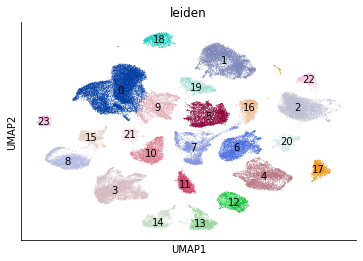

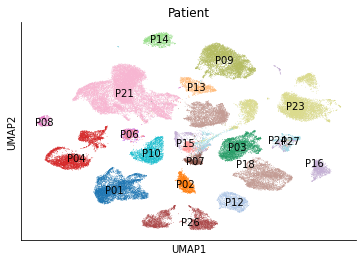

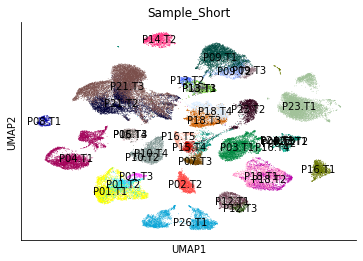

In [19]:
for c in ['leiden','Patient','Sample_Short']:
    fig = sc.pl.umap(tumor,color=[c],
                      legend_loc='on data',legend_fontweight='normal',legend_fontsize=10,
                     return_fig=True)
    fig.savefig(f'{FIGURE_FOLDER}/UMAP/GEX_Tumor_{c}.png')

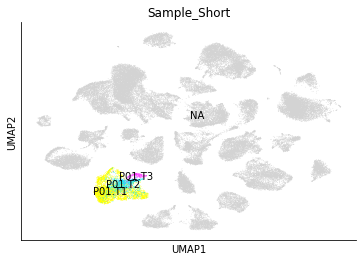

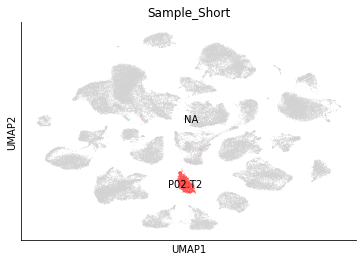

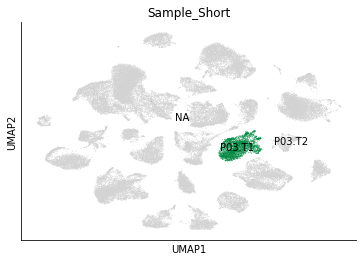

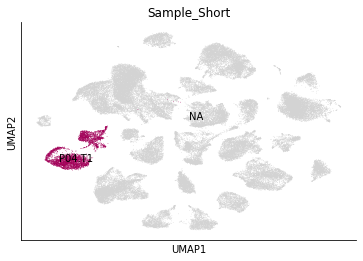

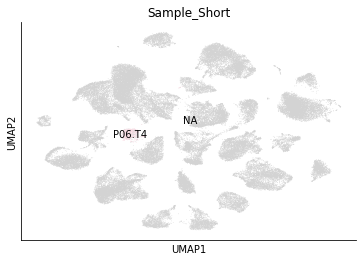

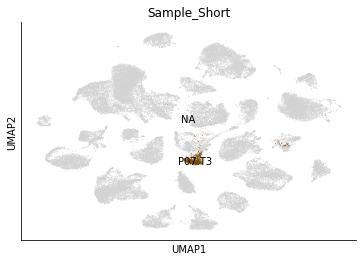

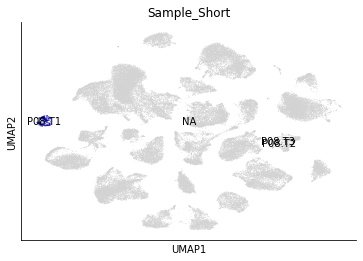

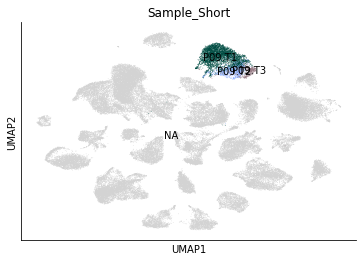

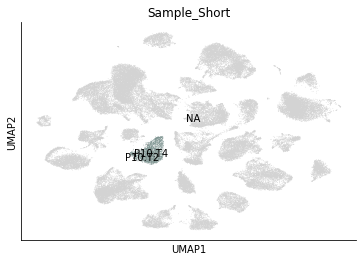

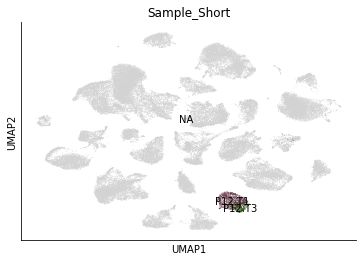

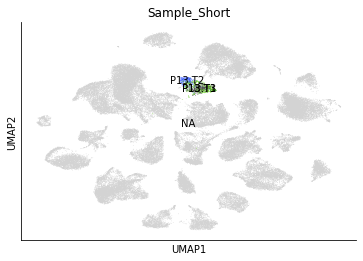

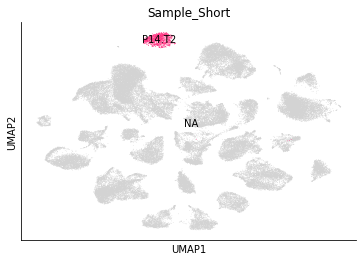

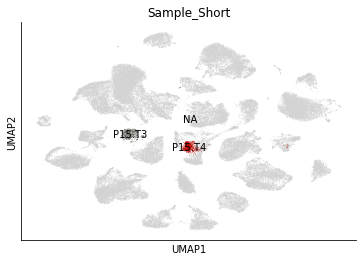

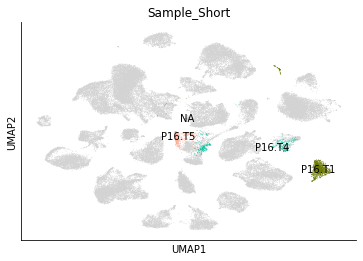

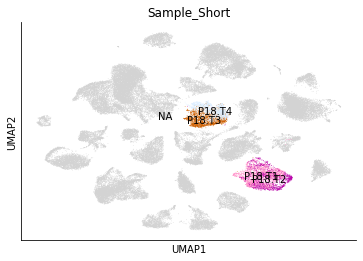

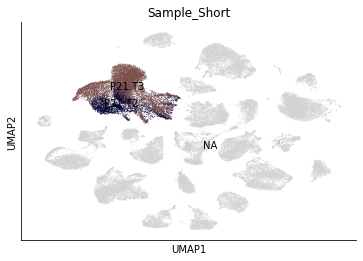

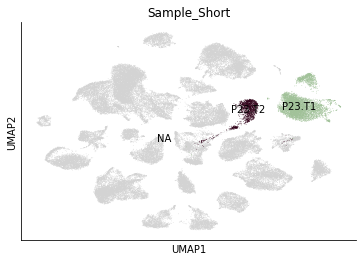

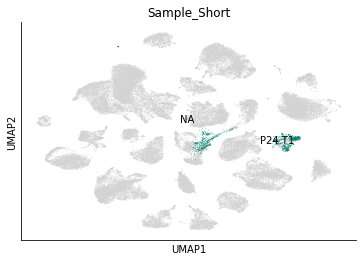

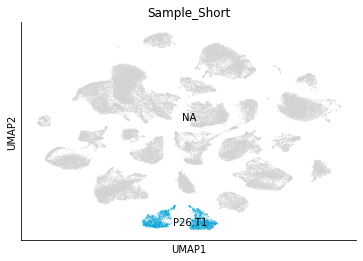

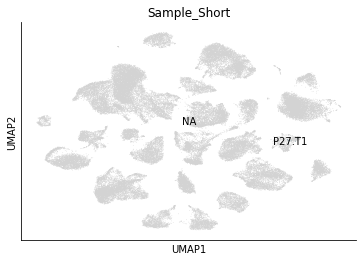

In [23]:
import matplotlib.backends.backend_pdf
with matplotlib.backends.backend_pdf.PdfPages(f'{FIGURE_FOLDER}/UMAP/GEX_Tumor_Sample.pdf') as pdf:
    for pt,df in tumor.obs.groupby('Patient'):
        groups = df['Sample_Short'].unique()
        fig = sc.pl.umap(tumor,color=['Sample_Short'],groups=groups,
                      legend_loc='on data',legend_fontweight='normal',legend_fontsize=10,
                     return_fig=True)
        pdf.savefig(fig)